This is just a WIP script to visualized computed results.

In [8]:
# dependencies

from src.data_analysis.query_accuracy import query_accuracy
import matplotlib.pyplot as plt
import glob
from copy import copy


%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.style.use("bmh")

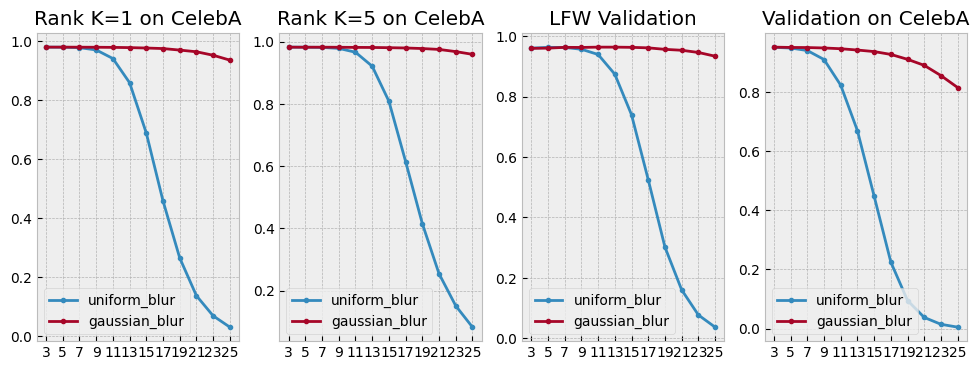

In [9]:
# looking at blurring results, comparing rank k on CelebA to lfw validation
fig, ax = plt.subplots(1, 4)

for privacy_mechanism in ["uniform_blur", "gaussian_blur"]:
    blur_kernels = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths[182638:])

    zeros = [0 for _ in range(len(blur_kernels))]
    rank_k_accs, rank_k5_accs, val_accs, val2_accs = (
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(blur_kernels)):
        kernel = blur_kernels[i]
        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = rank_k_accuracies["1"]
            rank_k5_accs[i] = rank_k_accuracies["5"]
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

        try:
            val_acc = query_accuracy(
                "lfw_validation",
                dataset="lfw",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=3000,
            )
            val_accs[i] = val_acc
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

        try:
            val2_acc = query_accuracy(
                "validation",
                dataset="CelebA",
                p_mech_suffix=f"{privacy_mechanism}_{kernel}",
                mode="mean",
                denominator=5000,
            )
            val2_accs[i] = val2_acc
        except Exception:
            print(f"No data for {privacy_mechanism}_{kernel}.")

    ax[0].plot(blur_kernels, rank_k_accs, label=privacy_mechanism, marker=".")
    ax[1].plot(blur_kernels, rank_k5_accs, label=privacy_mechanism, marker=".")
    ax[2].plot(blur_kernels, val_accs, label=privacy_mechanism, marker=".")
    ax[3].plot(blur_kernels, val2_accs, label=privacy_mechanism, marker=".")

ax[0].set_title("Rank K=1 on CelebA")
ax[0].legend()
ax[1].set_title("Rank K=5 on CelebA")
ax[1].legend()
ax[2].set_title("LFW Validation")
ax[2].legend()
ax[3].set_title("Validation on CelebA")
ax[3].legend()

ax[0].set_xticks(blur_kernels)
ax[1].set_xticks(blur_kernels)
ax[2].set_xticks(blur_kernels)
ax[3].set_xticks(blur_kernels)

plt.show()